In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import sys

import mne



from mne.event import define_target_events
from mne.channels import make_1020_channel_selections
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)

import sklearn

import os
from glob import glob
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import ttest_1samp

In [2]:

## read data
#subj_idx
subjects = ['sub-001', 
                 'sub-003', 
                 #'sub-004', #
                 'sub-005', 
                 'sub-006', 
                 'sub-007', #
                 'sub-008', 
                 'sub-009', #
                 'sub-010', 
                 'sub-011', #
                 'sub-012',
                 'sub-013', #
                 'sub-014', #
                 'sub-015', 
                 'sub-016',
                 'sub-017']
# task
tasks=[]
for side in ['outside','inside']:
    task='sourcedata-eeg_'+side+'-MRT'
    tasks.append(task)
# runs
runs=[]
for task in tasks:
    if task == tasks[0]:
        side = 'outside'
        for i in range(1,3):
            run = side+'MRT_run-0'+str(i)+'_beh.tsv'
            runs.append(run)
    else:
        side='inside'
        for i in range(1,6):
            run = side+'MRT_run-0'+str(i)+'_beh.tsv'
            runs.append(run)

# df_dirs: path + subj_idx + task + datatype + run
df_dirs=[]
temp_dir =os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))))
BIDS_data="2_Data\\Ostwald2018\\BIDS_data"
datatype='beh'
for subj_idx in subjects :
    for task in tasks:
        if task==tasks[0]:
            for run_index in range(0,2):
                run=runs[run_index]
                run=subj_idx+'_task-pdm_acq-'+run
                df_dir=os.path.join(temp_dir,BIDS_data,subj_idx,task,datatype,run)
                df_dirs.append(df_dir)
        else:
            pass

dfs=pd.DataFrame()
for df_dir in df_dirs:
    if os.path.exists(df_dir):
        df=pd.read_csv(df_dir,sep='\t')
        subject=''.join(re.findall(r'BIDS_data\\(.+?)\\sourcedata',df_dir))
        side=''.join(re.findall(r'\\sourcedata-eeg_(.+?)-MRT\\beh\\',df_dir))
        run=''.join(re.findall(r'run-0(.+?)_beh',df_dir))
        df['subject']=subject
        df['side']=side
        df['run']=int(run)
        dfs=pd.concat([df,dfs])
    else:
        pass

## clean data
dfs['attention'] = dfs['prioritization_cue'].map({74:'left',75:'right',76:'double'},na_action=None)
dfs['coherency']=dfs['condition'].map({1:'high',2:'high',3:'low',4:'low'})
dfs['prioritization']=dfs['condition'].map({1:'yes',2:'no',3:'yes',4:'no'})

car_images=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54]
face_images=[19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72]
dfs['category']=dfs['image_index'].isin(car_images).astype(int).map({1:'car', 0:'face'})

bedata = dfs.loc[:,['response_time','response_corr','subject','attention','coherency','prioritization','category','run']]
bedata.rename(columns={'response_time':'rt','response_corr':'response','subject':'subj_idx','category':'stimulus'},inplace = True)
bedata.loc[(bedata['response']==1)&(bedata['stimulus']=='face'),'_response'] = 0 #face
bedata.loc[(bedata['response']==1)&(bedata['stimulus']=='car'),'_response'] = 1 #car
bedata.loc[(bedata['response']==0)&(bedata['stimulus']=='face'),'_response'] = 0
bedata.loc[(bedata['response']==0)&(bedata['stimulus']=='car'),'_response'] = 1
bedata['id']=bedata.index
bedata = bedata.sort_values(by=['run','id'], axis=0, ascending=True)

In [3]:
event_dict = {
  'Response/car': 5,
  'Response/face': 6,
  'Stimulus/hc/p/left': 10,
  'Stimulus/hc/p/right': 11,
  'Stimulus/hc/np/left': 20,
  'Stimulus/hc/np/right': 21,
  'Stimulus/lc/p/left': 30,
  'Stimulus/lc/p/right': 31,
  'Stimulus/lc/np/left': 40,
  'Stimulus/lc/np/right': 41,
  'Cue/Left': 74,
  'Cue/Right': 75,
  'Cue/double': 76
}

cue_dict =  {
  'Cue/Left': 74,
  'Cue/Right': 75,
  'Cue/double': 76
}

stimulus_dict = {
  'Stimulus/hc/p/left': 10,
  'Stimulus/hc/p/right': 11,
  'Stimulus/hc/np/left': 20,
  'Stimulus/hc/np/right': 21,
  'Stimulus/lc/p/left': 30,
  'Stimulus/lc/p/right': 31,
  'Stimulus/lc/np/left': 40,
  'Stimulus/lc/np/right': 41,
}

response_dict = {
  'Response/car': 5,
  'Response/face': 6,
}

color1 = "#487ced"
color2 = "#e5493b"
color3 = "#37a656"

In [4]:
sdf = pd.DataFrame()
edf = pd.DataFrame()
for subject in subjects:

#stimulus_locked
    
    preprocessed = os.path.join(subject + ".fif")
    
    edata_path = os.path.join(os.path.dirname(os.getcwd()),'2_4_3_tmp_data', preprocessed)
    
    edata = mne.read_epochs(edata_path)

    bedata_subj = bedata.loc[bedata['subj_idx']==subject]

    epochs_cp = edata.pick_channels(['CPz','CP1','CP2'])
    edata_cp = epochs_cp.get_data()
    edata_cp = np.mean(edata_cp,axis=1)

    where = np.array(np.where(bedata.loc[bedata['subj_idx']==subject,'rt'].isnull()))[0]
    bedata.loc[bedata['subj_idx']==subject,'index'] = np.arange(288)

    bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'labels'] = pd.qcut(bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'rt'], q = 3, labels = ['fast','middle','slow'])
   
    time_label = bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'labels'].to_numpy() 
    edata_df = pd.DataFrame(edata_cp)
    edata_df.loc[edata_df.index.isin(np.setdiff1d(np.arange(288), where)),'subj_idx'] = bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'subj_idx'].to_numpy() 
    edata_df.loc[edata_df['subj_idx']==subject,'rt']=bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'rt'].to_numpy() 
    
    edata_df.loc[edata_df['subj_idx']==subject,'label']=time_label
    sdf = pd.concat([sdf,edata_df],axis = 0)



#response locked
    preprocessed = os.path.join(subject + "_res.fif")
    
    edata_path = os.path.join(os.path.dirname(os.getcwd()),'2_4_3_tmp_data', preprocessed)
    
    edata = mne.read_epochs(edata_path)

    bedata_subj = bedata.loc[bedata['subj_idx']==subject]

    epochs_cp = edata.pick_channels(['CPz','CP1','CP2'])
    edata_cp = epochs_cp.get_data()
    edata_cp = np.mean(edata_cp,axis=1)

    where = np.array(np.where(bedata.loc[bedata['subj_idx']==subject,'rt'].isnull()))[0]
    bedata.loc[bedata['subj_idx']==subject,'index'] = np.arange(288)

    bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'labels'] = pd.qcut(bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'rt'], q = 3, labels = ['fast','middle','slow'])
   
    time_label = bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'labels'].to_numpy() 
    edata_df = pd.DataFrame(edata_cp)
    
    edata_df['subj_idx'] = bedata.loc[((bedata['subj_idx']==subject)&(bedata.loc[:,'index'].isin(np.setdiff1d(np.arange(288), where)))),'subj_idx'].to_numpy() 
    edata_df.loc[edata_df['subj_idx']==subject,'label']=time_label
    edf = pd.concat([edf,edata_df],axis = 0)


Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-001.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-001.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-001_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-001_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-003.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-003.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-003_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-003_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-005.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-005.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-005_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-005_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-006.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-006.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-006_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-006_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-007.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-007.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-007_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-007_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-008.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-008.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-008_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-008_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-009.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-009.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-009_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-009_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
286 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-010.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-010.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-010_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-010_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-011.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-011.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-011_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-011_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
254 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-012.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-012.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-012_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-012_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-013.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-013.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-013_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-013_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
287 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-014.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-014.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-014_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-014_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
284 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-015.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-015.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-015_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-015_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-016.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-016.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-016_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-016_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-017.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:11: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-017.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Reading d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-017_res.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 62) active
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


C:\Users\LIUYIK~1\AppData\Local\Temp/ipykernel_17692/1943526765.py:39: RuntimeWarning: This filename (d:\yikang1020\yikangsystem1020\2_Projects\202206_Centro-parietal positivity\2_Study\2_4_Analysis\2_4_3_tmp_data\sub-017_res.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  edata = mne.read_epochs(edata_path)


Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


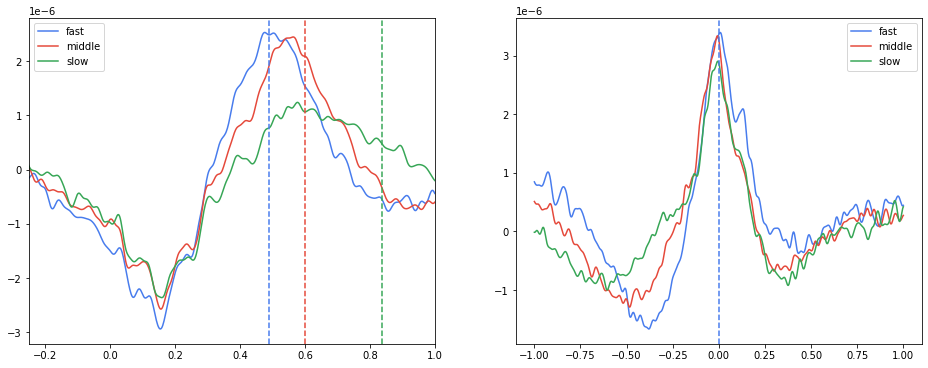

In [5]:

y = sdf.groupby('label').mean()
x = np.arange(1025)/512 - 1

fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(121)
plt.plot(x,y.iloc[0,:-1], label='fast',color=color1)
plt.plot(x,y.iloc[1,:-1], label='middle',color=color2)
plt.plot(x,y.iloc[2,:-1],label='slow',color=color3)
plt.legend()
plt.axvline(bedata.loc[bedata['labels']=='fast','rt'].mean()+0.2, ls = '--',color=color1)
plt.axvline(bedata.loc[bedata['labels']=='middle','rt'].mean()+0.2, ls = '--',color=color2)
plt.axvline(bedata.loc[bedata['labels']=='slow','rt'].mean()+0.2, ls = '--',color=color3)
#plt.savefig(os.path.join(subject+'_pz.png'))
ax1.set_xlim(-0.25, 1)



y = edf.groupby('label').mean()
x = np.arange(1025)/512 - 1


ax2 = plt.subplot(122)
plt.plot(x,y.loc['fast',:], label='fast',color=color1)
plt.plot(x,y.loc['middle',:], label='middle',color=color2)
plt.plot(x,y.loc['slow',:],label='slow',color=color3)
plt.legend()
plt.axvline(0, ls = '--',color=color1)

#plt.savefig(os.path.join(subject+'_res_pz.png'))


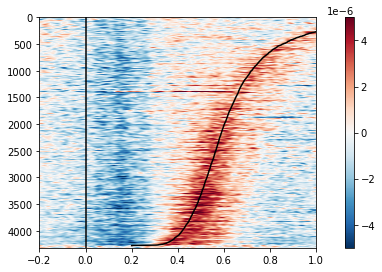

In [41]:
sdf = sdf.sort_values(by=['rt'], axis=0, ascending=False)
values = sdf.iloc[:,:-3].reset_index(drop=True)
rt = sdf.iloc[:,-2].reset_index(drop=True)
values.columns = values.columns/512-1



plt.imshow(values,
                    vmin=-5e-6,
                    vmax=5e-6,
                    cmap='RdBu_r',
                    aspect=1/4320,
                    extent=[-1,1,4320,0]
                    )
plt.axvline(0,color='black')
plt.plot(rt+0.2,rt.index,color = 'black')
plt.xlim([-0.2,1])

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.02, 0.8])
plt.colorbar(cax=cax)

plt.show()


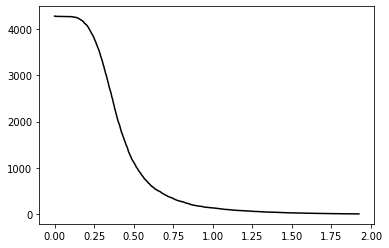

In [49]:
plt.plot(rt,rt.index,color = 'black')

In [37]:
rt

0       1.924480
1       1.904793
2       1.882941
3       1.832549
4       1.800999
          ...   
4315         NaN
4316         NaN
4317         NaN
4318         NaN
4319         NaN
Name: rt, Length: 4320, dtype: float64